In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from helper_functions_paper import *

In [2]:
def rename(df):
    df['modelname_old'] = df['modelname']
    df['modelname'] = df['modelname'].replace('least_squares', 'K-means: Least squares \n(sign-flipped eigenvectors)')
    df['modelname'] = df['modelname'].replace('diametrical', 'K-means: Diametrical')
    df['modelname'] = df['modelname'].replace('complex_diametrical', 'K-means: Complex diametrical')
    df['modelname'] = df['modelname'].replace('grassmann', 'K-means: Grassmann')
    df['modelname'] = df['modelname'].replace('weighted_grassmann', 'K-means: Weighted Grassmann')
    df['modelname'] = df['modelname'].replace('Watson', 'Mixture: Watson')
    df['modelname'] = df['modelname'].replace('Complex_Watson', 'Mixture: Complex Watson')
    df['modelname'] = df['modelname'].replace('ACG', 'Mixture: ACG')
    df['modelname'] = df['modelname'].replace('Complex_ACG', 'Mixture: Complex ACG')
    df['modelname'] = df['modelname'].replace('MACG', 'Mixture: MACG')
    df['modelname'] = df['modelname'].replace('SingularWishart', 'Mixture: Singular Wishart')
    df['modelname'] = df['modelname'].replace('Normal', 'Mixture: Gaussian')
    df['modelname'] = df['modelname'].replace('Complex_Normal', 'Mixture: Complex Gaussian')
    df['Set'] = df['Set'].replace('train', 'Train')
    df['Set'] = df['Set'].replace('test1', 'Within-subject test')
    df['Set'] = df['Set'].replace('test2', 'Out-of-sample test')
    # if column LR doesnt exist, make it with zeros
    if 'LR' not in df.columns:
        df['LR'] = 0
    if 'HMM' not in df.columns:
        df['HMM'] = False

    names = [] #without the Kmeans or Mixture or HMM
    names2 = [] #with
    for i in range(len(df)):
        if 'Watson' in df['modelname'].iloc[i]:
            add_rank = ''
        else:
            add_rank = ' rank='+str(df['rank'].iloc[i])
        if df['HMM'].iloc[i]:
            add_HMM = 'HMM: '
        else:
            add_HMM = ''
        if 'Mixture' in df['modelname'].iloc[i]:
            names.append(df['modelname'].iloc[i][8:]+add_rank)
            if df['HMM'].iloc[i]:
                names2.append(add_HMM + df['modelname'].iloc[i][8:]+add_rank)
            else:
                names2.append(add_HMM + df['modelname'].iloc[i]+add_rank)
        else:
            names.append(df['modelname'].iloc[i][:8])
            names2.append(df['modelname'].iloc[i])
            
    df['names'] = names
    df['names2'] = names2
    df['Accuracy'] = df['classification_accuracy']
    return df

In [ ]:
df1 = pd.read_csv('../data/results/116_results/REST1REST2rank_realdata_Complex_ACG_K=1.csv')
df2 = pd.read_csv('../data/results/116_results/REST1REST2rank_realdata_Complex_Normal_K=1.csv')
df3 = pd.read_csv('../data/results/116_results/REST1REST2rank_realdata_Normal_K=1.csv')
df_rank = pd.concat([df1,df2,df3])
df_rank = rename(df_rank)
df_rank = df_rank[df_rank['inner']==0]

In [4]:
#model order loglik data
df3 = pd.DataFrame()
modelnames = ['Normal','Complex_ACG','Complex_Normal']
for modelname in modelnames:
    for rank in [1,10,25,50,100]:
        for K in range(1,11):
            try:
                df = pd.read_csv('../data/results/116_results/REST1REST2modelorder_realdata_'+modelname+'_K='+str(K)+'_rank='+str(rank)+'.csv')
            except:
                print('No file for modelname',modelname,'K',K, 'rank',rank)
                continue
            df3 = pd.concat([df3,df])
df3 = rename(df3)
df4 = df3[df3['Set']=='Out-of-sample test']
# df4 = df3[df3['Set']=='Within-subject test']

In [5]:
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_reduced = [palette_husl[1],(0.5,0.5,0.5),(0.3,0.3,0.3)]

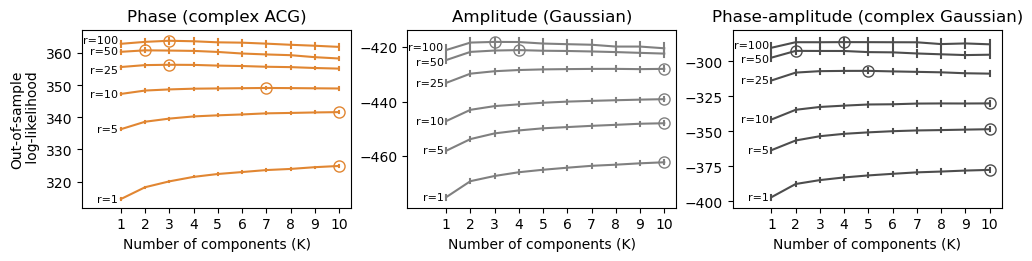

In [ ]:
order2 = ['Mixture: Complex ACG','Mixture: Gaussian','Mixture: Complex Gaussian']

# palette_reduced2 = [palette_reduced[0],palette_reduced[2],palette_reduced[1]]
fig,axs = plt.subplots(1, 3, figsize=(10, 2.5),layout='constrained')
for i,model in enumerate(order2):
    for r in [1,5,10,25,50,100]:
        df_tmp = df4[df4['names2']==model+' rank='+str(r)]
        #choose only columns K and loglik
        df_tmp = df_tmp[['K','loglik','modelname']]
        sns.lineplot(x='K',y='loglik',data=df_tmp,hue='modelname', palette=[palette_reduced[i]], linewidth=1.5,err_style='bars',errorbar='se',legend=False,ax=axs[i])
        
        df_avg = df_tmp.groupby(['K','modelname']).mean().reset_index()
        maxidx = df_avg['loglik'].argmax()
        axs[i].plot(df_avg['K'].iloc[maxidx],df_avg['loglik'].iloc[maxidx],'o',color=palette_reduced[i],fillstyle='none',markersize=8,markeredgewidth=1)
        # axs[1,i].text(0.5, 0.95, 'Rank = '+str(r), fontsize=8)
    if i==0:
        axs[i].set_ylabel('Out-of-sample\n log-likelihood')
    else:
        axs[i].set_ylabel('')
    if i==1:
        axs[i].set_title('Amplitude (Gaussian)')
    if i==0:
        axs[i].set_title('Phase (complex ACG)')
    if i==2:
        axs[i].set_title('Phase-amplitude (complex Gaussian)')
    axs[i].set_xlim(-0.6,10.5)
    axs[i].set_xticks([1,2,3,4,5,6,7,8,9,10])
    # axs[1,i].set_ylim(np.mean(df4[(df4['names2']==model+' rank=1')&(df4['K']==1)]['loglik'])-5, np.mean(df4[(df4['names2']==model+' rank=100')&(df4['K']==2)]['loglik'])+10)
    axs[i].set_xlabel('Number of components (K)')

xpos = 0.90
axs[1].text(xpos, df4[(df4['names2']=='Mixture: Gaussian rank=1')&(df4['K']==1)]['loglik'].mean(), 'r=1', fontsize=8,ha='right',va='center');
axs[1].text(xpos, df4[(df4['names2']=='Mixture: Gaussian rank=5')&(df4['K']==1)]['loglik'].mean(), 'r=5', fontsize=8,ha='right',va='center');
axs[1].text(xpos, df4[(df4['names2']=='Mixture: Gaussian rank=10')&(df4['K']==1)]['loglik'].mean(), 'r=10', fontsize=8,ha='right',va='center');
axs[1].text(xpos, df4[(df4['names2']=='Mixture: Gaussian rank=25')&(df4['K']==1)]['loglik'].mean(), 'r=25', fontsize=8,ha='right',va='center');
axs[1].text(xpos, -1+df4[(df4['names2']=='Mixture: Gaussian rank=50')&(df4['K']==1)]['loglik'].mean(), 'r=50', fontsize=8,ha='right',va='center');
axs[1].text(xpos, +1+df4[(df4['names2']=='Mixture: Gaussian rank=100')&(df4['K']==1)]['loglik'].mean(), 'r=100', fontsize=8,ha='right',va='center');

axs[0].text(xpos, df4[(df4['names2']=='Mixture: Complex ACG rank=1')&(df4['K']==1)]['loglik'].mean(), 'r=1', fontsize=8,ha='right',va='center');
axs[0].text(xpos, df4[(df4['names2']=='Mixture: Complex ACG rank=5')&(df4['K']==1)]['loglik'].mean(), 'r=5', fontsize=8,ha='right',va='center');
axs[0].text(xpos, df4[(df4['names2']=='Mixture: Complex ACG rank=10')&(df4['K']==1)]['loglik'].mean(), 'r=10', fontsize=8,ha='right',va='center');
axs[0].text(xpos, -1+df4[(df4['names2']=='Mixture: Complex ACG rank=25')&(df4['K']==1)]['loglik'].mean(), 'r=25', fontsize=8,ha='right',va='center');
axs[0].text(xpos, -0+df4[(df4['names2']=='Mixture: Complex ACG rank=50')&(df4['K']==1)]['loglik'].mean(), 'r=50', fontsize=8,ha='right',va='center');
axs[0].text(xpos, +1+df4[(df4['names2']=='Mixture: Complex ACG rank=100')&(df4['K']==1)]['loglik'].mean(), 'r=100', fontsize=8,ha='right',va='center');

axs[2].text(xpos, df4[(df4['names2']=='Mixture: Complex Gaussian rank=1')&(df4['K']==1)]['loglik'].mean(), 'r=1', fontsize=8,ha='right',va='center');
axs[2].text(xpos, df4[(df4['names2']=='Mixture: Complex Gaussian rank=5')&(df4['K']==1)]['loglik'].mean(), 'r=5', fontsize=8,ha='right',va='center');
axs[2].text(xpos, df4[(df4['names2']=='Mixture: Complex Gaussian rank=10')&(df4['K']==1)]['loglik'].mean(), 'r=10', fontsize=8,ha='right',va='center');
axs[2].text(xpos, df4[(df4['names2']=='Mixture: Complex Gaussian rank=25')&(df4['K']==1)]['loglik'].mean(), 'r=25', fontsize=8,ha='right',va='center');
axs[2].text(xpos, -1.5+df4[(df4['names2']=='Mixture: Complex Gaussian rank=50')&(df4['K']==1)]['loglik'].mean(), 'r=50', fontsize=8,ha='right',va='center');
axs[2].text(xpos, +1.5+df4[(df4['names2']=='Mixture: Complex Gaussian rank=100')&(df4['K']==1)]['loglik'].mean(), 'r=100', fontsize=8,ha='right',va='center');
fig.savefig('figures/resting_state_curves_v2.pdf')

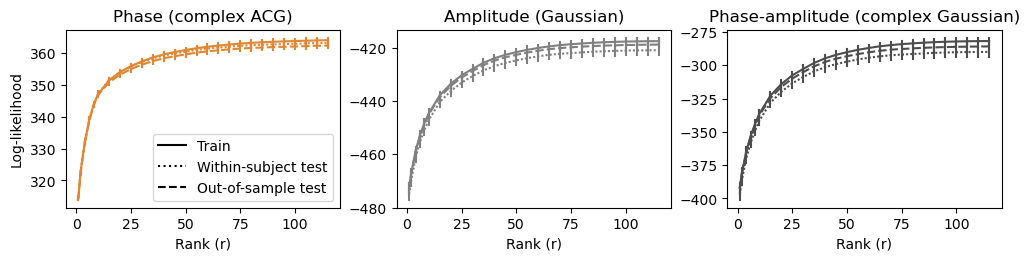

In [ ]:
df_rank['modelname'] = df_rank['modelname'].replace('Complex_ACG','Mixture: Complex ACG')
df_rank['modelname'] = df_rank['modelname'].replace('Complex_Normal','Mixture: Complex Gaussian')
df_rank['modelname'] = df_rank['modelname'].replace('Normal','Mixture: Gaussian')
df_rank['Model'] = df_rank['modelname']
order2 = ['Mixture: Complex ACG','Mixture: Gaussian','Mixture: Complex Gaussian']
fig,axs = plt.subplots(1, 3, figsize=(10, 2.5),layout='constrained')
for i,model in enumerate(order2):
    sns.lineplot(x='rank', y='loglik', data=df_rank[df_rank['Model']==model],style='Set',hue='Model', palette=[palette_reduced[i]], linewidth=1.5,err_style='bars',errorbar='se',legend=False,ax=axs[i])
    if i==0:
        axs[i].set_ylabel('Log-likelihood')
        axs[i].legend([plt.plot([],color='black')[0], plt.plot([],color='black',linestyle=':')[0], plt.plot([],color='black',linestyle='--')[0]], 
           ['Train', 'Within-subject test', 'Out-of-sample test'],loc='lower right')
    else:
        axs[i].set_ylabel('')
    axs[i].set_xlabel('Rank (r)')
    if i==1:
        axs[i].set_title('Amplitude (Gaussian)')
    if i==0:
        axs[i].set_title('Phase (complex ACG)')
    if i==2:
        axs[i].set_title('Phase-amplitude (complex Gaussian)')
fig.savefig('figures/rest_curves_rank.pdf')